In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.optim import AdamW
from torch.amp import autocast
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, log_loss

load_dotenv()

True

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
os.environ["HF_HOME"] = os.getenv("HF_HOME")
os.environ["HF_HOME"]

'/media/luna/huggingface'

In [5]:
DATA_DIR = os.getenv("DATA_DIR")
DATA_DIR

'data'

In [6]:
MODELS_DIR = os.getenv("MODELS_DIR")
MODELS_DIR

'models'

In [7]:
STATISTIC_DIR = os.getenv("STATISTIC_DIR")
STATISTIC_DIR

'statistic'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

In [9]:
train_data = pd.read_json(os.path.join(DATA_DIR, 'data_final_for_dls_new.jsonl'), orient='orient', lines=True)[570:]
train_data = train_data[train_data['relevance'] != 0.1]
train_data = train_data.fillna("")
train_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
570,налоговая 5007,"Московская область, Королёв, улица Богомолова, 4",Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,1377658436,,0.0,Организация занимается обслуживанием налогопла...,0.0
571,шугаринг Красноярск,"Красноярск, микрорайон Взлётка, улица Весны, 3",Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,1085001465,Студия красоты «Дарлинг» предоставляет услуги ...,1.0,Студия красоты «Дарлинг» предоставляет бьюти-у...,1.0
573,новогодняя ночь 2018 в ресторане,"Москва, Кутузовский проспект, 36А",Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,1187477091,Ресторан Atlantica предлагает разнообразные бл...,1.0,Организация занимается ресторанным бизнесом и ...,1.0
574,балетная школа в санкт петербурге 12лет с прож...,"Санкт-Петербург, Невский проспект, 35В",Русская национальная балетная школа Илзе Лиепа...,Школа танцев,172170646460,,0.0,Организация занимается обучением балету и хоре...,0.0
575,солкосерил гель цена,"Москва, Симферопольский бульвар, 29, корп. 1",Столички; Stolichki; Apteki Stolichki,Аптека,226500195223,Аптека «Столички» предлагает широкий спектр ле...,1.0,Организация занимается продажей лекарств и мед...,1.0
...,...,...,...,...,...,...,...,...,...
35089,нотариус запись,"Москва, 15-я Парковая улица, 45",Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,1056199530,,1.0,Организация предоставляет нотариальные услуги ...,1.0
35090,стационар для кота москва,"Москва, улица Госпитальный Вал, 3, корп. 5",ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,133156701339,"Ветеринарная клиника, аптека и лаборатория «Тр...",0.0,"Организация занимается ветеринарными услугами,...",0.0
35091,агзс пропан,"Самара, улица 22-го Партсъезда, 49, корп. 1",Роза Мира; АЗС № 2; Роза мира,АЗС,6884296946,,0.0,Организация занимается заправкой транспортных ...,0.0
35092,где вибрить ваз 2112,"Нижний Новгород, Московское шоссе, 34","Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,124836381099,Автосалон «Нижегородец» предлагает новые автом...,0.0,Автосалон «Нижегородец» занимается продажей и ...,0.0


In [10]:
X = train_data.drop(columns=['relevance', 'relevance_new', 'address', 'permalink'])
X

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized
570,налоговая 5007,Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,,Организация занимается обслуживанием налогопла...
571,шугаринг Красноярск,Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...
573,новогодняя ночь 2018 в ресторане,Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...
574,балетная школа в санкт петербурге 12лет с прож...,Русская национальная балетная школа Илзе Лиепа...,Школа танцев,,Организация занимается обучением балету и хоре...
575,солкосерил гель цена,Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...
...,...,...,...,...,...
35089,нотариус запись,Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,,Организация предоставляет нотариальные услуги ...
35090,стационар для кота москва,ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,..."
35091,агзс пропан,Роза Мира; АЗС № 2; Роза мира,АЗС,,Организация занимается заправкой транспортных ...
35092,где вибрить ваз 2112,"Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...


In [11]:
# Объединение текстовых полей
def combine_fields(row):
    return f"Запрос: {row['Text']} | Название: {row['name']} | Рубрика: {row['normalized_main_rubric_name_ru']} | Описание: {row['prices_summarized']} | Отзывы: {row['reviews_summarized']}"

In [12]:
X['combined_fields'] = X.apply(combine_fields, axis=1)
X

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized,combined_fields
570,налоговая 5007,Налоговая служба; Межрайонная ИФНС № 2; ИФНС №...,Налоговая инспекция,,Организация занимается обслуживанием налогопла...,Запрос: налоговая 5007 | Название: Налоговая с...
571,шугаринг Красноярск,Студия красоты Дарлинг; Darling; Дарлинг,Салон красоты,Студия красоты «Дарлинг» предоставляет услуги ...,Студия красоты «Дарлинг» предоставляет бьюти-у...,Запрос: шугаринг Красноярск | Название: Студия...
573,новогодняя ночь 2018 в ресторане,Atlantica seafood; Коллекция; Коллекция Food &...,Ресторан,Ресторан Atlantica предлагает разнообразные бл...,Организация занимается ресторанным бизнесом и ...,Запрос: новогодняя ночь 2018 в ресторане | Наз...
574,балетная школа в санкт петербурге 12лет с прож...,Русская национальная балетная школа Илзе Лиепа...,Школа танцев,,Организация занимается обучением балету и хоре...,Запрос: балетная школа в санкт петербурге 12ле...
575,солкосерил гель цена,Столички; Stolichki; Apteki Stolichki,Аптека,Аптека «Столички» предлагает широкий спектр ле...,Организация занимается продажей лекарств и мед...,Запрос: солкосерил гель цена | Название: Столи...
...,...,...,...,...,...,...
35089,нотариус запись,Нотариус О. Н. Савина; Notarius O. N. Savina; ...,Нотариусы,,Организация предоставляет нотариальные услуги ...,Запрос: нотариус запись | Название: Нотариус О...
35090,стационар для кота москва,ТриоВет; Triovet; Триовет; Veterinaria Triovet,Ветеринарная клиника,"Ветеринарная клиника, аптека и лаборатория «Тр...","Организация занимается ветеринарными услугами,...",Запрос: стационар для кота москва | Название: ...
35091,агзс пропан,Роза Мира; АЗС № 2; Роза мира,АЗС,,Организация занимается заправкой транспортных ...,Запрос: агзс пропан | Название: Роза Мира; АЗС...
35092,где вибрить ваз 2112,"Нижегородец, Lada; Nizhegorodec, Lada; Нижегор...",Автосалон,Автосалон «Нижегородец» предлагает новые автом...,Автосалон «Нижегородец» занимается продажей и ...,Запрос: где вибрить ваз 2112 | Название: Нижег...


In [13]:
y = train_data['relevance_new']
y

570      0.0
571      1.0
573      1.0
574      0.0
575      1.0
        ... 
35089    1.0
35090    0.0
35091    0.0
35092    0.0
35093    0.0
Name: relevance_new, Length: 29891, dtype: float64

In [14]:
texts = X['combined_fields'].to_list()
labels = y.to_list()

In [15]:
models_dir = f"models"
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

In [16]:
# Загружаем модель
# model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
# model_name = "DeepPavlov/rubert-base-cased"
# model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_name = "deepseek-ai/deepseek-llm-7b-base"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_name = "xlm-roberta-base"
# model_name = "IlyaGusev/saiga_yandexgpt_8b"
model_name = "sberbank-ai/ruBert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [17]:
# Класс Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        # self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


In [18]:
# Разделение данных
# Разделение на train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

In [19]:
batch_size = 16

In [20]:
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [21]:
class ClassifierModel(nn.Module):
    def __init__(self, model_name, dropout_rate=0.3, hidden_size=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(self.model_hidden_size, hidden_size),  # +1: для перплексии
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask):
        # outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        # combined = torch.cat([cls_embedding, perplexity.unsqueeze(1)], dim=1)
        # return self.classifier(combined)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # pooled_output = outputs.pooler_output  # [CLS]-токен
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        # logits = self.classifier(pooled_output)
        logits = self.classifier(cls_embedding)
        return logits

In [22]:
# Инициализация модели
model = ClassifierModel(model_name).to(device)

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=2e-5)

#Loss-функция
loss_fn = nn.BCEWithLogitsLoss()

In [23]:
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].unsqueeze(1).to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    return total_loss / len(train_loader)

In [24]:
def eval_model(model, val_loader, device):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs)
            pred_labels = (probs > 0.5).float()

            preds.extend(pred_labels.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)

    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    return acc, f1

In [25]:
model_filename = model_name.replace("/", "_")
model_filename

'sberbank-ai_ruBert-base'

In [26]:
def save_statistic(statistic: dict):
    with open(os.path.join(STATISTIC_DIR, f"{model_filename}.json"), encoding='utf-8', mode='w') as f:
        json.dump(statistic, f, indent=4, ensure_ascii=False)

def load_statistic():
    try:
        with open(os.path.join(STATISTIC_DIR, f"{model_filename}.json"), encoding='utf-8', mode='r') as f:
            return json.load(f)
    except FileNotFoundError:
        return []
    except json.JSONDecodeError:
        return []

In [27]:
start_epoch = 1
best_accuracy = 0
best_epoch = 0

## Загрузка модели для продолжения обучения

Использовать при дообучении ммодели. Иначе закомментировать.

In [28]:
# # Загрузка чекпоинта
# # checkpoint = torch.load(f'{models_dir}/{model_filename}_checkpoint.pth')
# checkpoint = torch.load(os.path.join(MODELS_DIR, f'{model_filename}_checkpoint.pth'))

# # Восстановление состояния
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1
# best_accuracy = checkpoint.get('best_accuracy', 0.0)  # если нужно
# best_epoch = checkpoint.get('best_epoch', 0)  # если нужно



In [29]:
statistic = load_statistic()
statistic

[{'epoch': 1,
  'train_loss': 0.5748330628800177,
  'val_f1': 0.7729452621134447,
  'val_accuracy': 0.7703629369459776},
 {'epoch': 2,
  'train_loss': 0.4509397348615088,
  'val_f1': 0.79328,
  'val_accuracy': 0.7839103529018231},
 {'epoch': 3,
  'train_loss': 0.3666158568715619,
  'val_f1': 0.8031064412973961,
  'val_accuracy': 0.7837431008529855},
 {'epoch': 4,
  'train_loss': 0.30422277677591253,
  'val_f1': 0.7937328379906315,
  'val_accuracy': 0.786419133634387},
 {'epoch': 5,
  'train_loss': 0.2648718786877533,
  'val_f1': 0.7750415973377703,
  'val_accuracy': 0.7738752299715671},
 {'epoch': 6,
  'train_loss': 0.2094667452353249,
  'val_f1': 0.7859820700896496,
  'val_accuracy': 0.7803980598762335},
 {'epoch': 7,
  'train_loss': 0.17362558508547254,
  'val_f1': 0.7290462427745664,
  'val_accuracy': 0.7491219267436026},
 {'epoch': 8,
  'train_loss': 0.13671827000101722,
  'val_f1': 0.7879371190247032,
  'val_accuracy': 0.7788927914366951}]

In [30]:
# Обучение
def train_loop():

    epochs = 4

    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        print(f"Train loss: {train_loss}")

        val_accuracy, val_f1 = eval_model(model, val_loader, device)

        if val_accuracy > best_accuracy:
            torch.save(model, os.path.join(MODELS_DIR, f'best_{model_filename}_checkpoint.pth'))
            best_accuracy = val_accuracy
            best_epoch = epoch + start_epoch

            with open(os.path.join(STATISTIC_DIR, f'best_{model_filename}.json'), mode="w") as f:
                json.dump({
                    "best_epoch": best_epoch,
                    "best_accuracy": val_accuracy
                }, f)

        statistic.append({
            "epoch": epoch + start_epoch,
            "train_loss": train_loss,
            "val_f1": val_f1,
            "val_accuracy": val_accuracy
        })
        save_statistic(statistic)



        # Save model with optimizator
        torch.save({
            'epoch': epoch+start_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': val_accuracy,
            'best_epoch': best_epoch,
            'best_accuracy': best_accuracy
        }, os.path.join(MODELS_DIR, f'{model_filename}_checkpoint.pth'))

In [31]:
# mode = 'train'
mode = 'eval'

In [32]:
if mode == 'train':
    train_loop()
elif mode == 'eval':
    # Загрузка чекпоинта
    model = torch.load(
        os.path.join(MODELS_DIR, f'best_{model_filename}_checkpoint.pth'),
        weights_only=False
    )

    # Восстановление состояния
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # start_epoch = checkpoint['epoch'] + 1
    # best_accuracy = checkpoint.get('best_accuracy', 0.0)  # если нужно
    # best_epoch = checkpoint.get('best_epoch', 0)  # если нужно

In [33]:
def draw_stats(stats: dict, start_from: int=0):
    metric_keys = [metric_name for metric_name in stats[0].keys() if metric_name != "epoch"]
    epochs = [record['epoch'] for record in stats]

    # Построение графиков по всем метрикам
    plt.figure(figsize=(10, 6))
    plt.title("Training History")

    for key in metric_keys:
        values = [record[key] for record in stats]
        plt.plot(epochs[start_from:], values[start_from:], label=key)
        
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

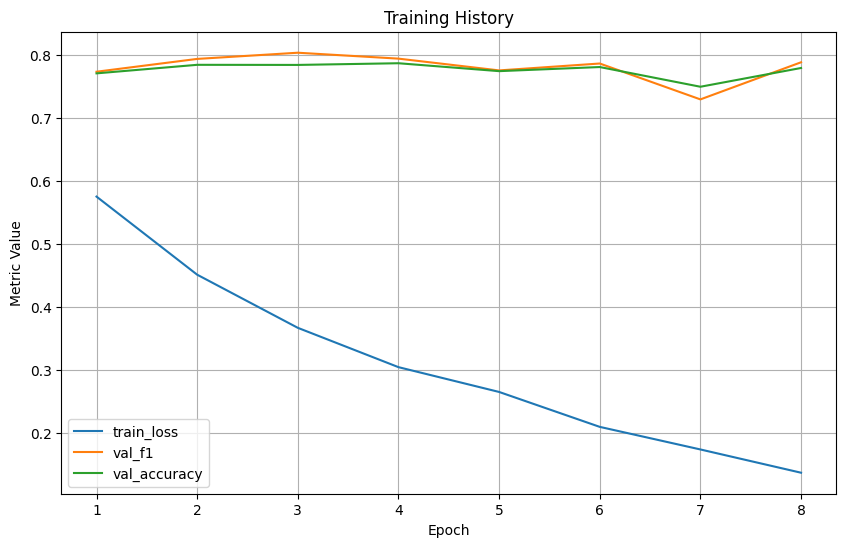

In [34]:
draw_stats(stats=statistic, start_from=0)

## EVALUATION (TEST)
Оценка качества модели на предоставленной eval выбоке из 500 строк

In [35]:
test_data = pd.read_json(os.path.join(DATA_DIR, 'data_final_for_dls_eval_new.jsonl'), orient='orient', lines=True)
test_data = test_data[test_data['relevance'] != 0.1]
test_data = test_data.fillna("")
test_data

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,relevance,reviews_summarized,relevance_new
0,сигары,"Москва, Дубравная улица, 34/29",Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,1263329400,,1.0,"Организация занимается продажей табака, курите...",1.0
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,0.0,"Организация PioNero — это кафе, бар и ресторан...",0.0
2,Эпиляция,"Московская область, Одинцово, улица Маршала Жу...",MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,1247255817,"Стоматологическая клиника, массажный салон и к...",1.0,"Организация занимается стоматологическими, кос...",1.0
4,стиральных машин,"Москва, улица Обручева, 34/63",М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,1074529324,М.Видео предлагает широкий ассортимент бытовой...,1.0,Организация занимается продажей бытовой техник...,1.0
5,сеть быстрого питания,"Санкт-Петербург, 1-я Красноармейская улица, 15",Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,1219173871,Rostic's предлагает различные наборы быстрого ...,1.0,"Организация занимается быстрым питанием, предо...",1.0
...,...,...,...,...,...,...,...,...,...
561,наращивание ресниц,"Саратов, улица имени А.С. Пушкина, 1",Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,236976975812,Салон красоты «Сила» предлагает услуги по уход...,1.0,Организация «Сила» занимается предоставлением ...,1.0
565,игры,"Москва, Щёлковское шоссе, 79, корп. 1",YouPlay; YouPlay КиберКлуб,Компьютерный клуб,109673025161,YouPlay КиберКлуб предлагает услуги по игре на...,0.0,Организация занимается предоставлением услуг к...,0.0
566,домашний интернет в курске что подключить отзы...,"Курск, Садовая улица, 5",Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,1737991898,,0.0,,0.0
567,гостиница волгодонск сауна номер телефона,"Ростовская область, городской округ Волгодонск...",Поплавок; Poplavok,"База , дом отдыха",147783493467,"Предлагает размещение в различных типах жилья,...",0.0,Организация «Поплавок» предлагает услуги базы ...,0.0


In [36]:
X_test = test_data.drop(columns=['relevance', 'relevance_new', 'address', 'permalink'])
X_test

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized
0,сигары,Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,,"Организация занимается продажей табака, курите..."
1,кальянная спб мероприятия,PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,PioNero предлагает разнообразные блюда итальян...,"Организация PioNero — это кафе, бар и ресторан..."
2,Эпиляция,MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,"Стоматологическая клиника, массажный салон и к...","Организация занимается стоматологическими, кос..."
4,стиральных машин,М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,М.Видео предлагает широкий ассортимент бытовой...,Организация занимается продажей бытовой техник...
5,сеть быстрого питания,Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,Rostic's предлагает различные наборы быстрого ...,"Организация занимается быстрым питанием, предо..."
...,...,...,...,...,...
561,наращивание ресниц,Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,Салон красоты «Сила» предлагает услуги по уход...,Организация «Сила» занимается предоставлением ...
565,игры,YouPlay; YouPlay КиберКлуб,Компьютерный клуб,YouPlay КиберКлуб предлагает услуги по игре на...,Организация занимается предоставлением услуг к...
566,домашний интернет в курске что подключить отзы...,Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,,
567,гостиница волгодонск сауна номер телефона,Поплавок; Poplavok,"База , дом отдыха","Предлагает размещение в различных типах жилья,...",Организация «Поплавок» предлагает услуги базы ...


In [37]:
X_test['combined_fields'] = X_test.apply(combine_fields, axis=1)
X_test

,Text,name,normalized_main_rubric_name_ru,prices_summarized,reviews_summarized,combined_fields
0,сигары,Tabaccos; Магазин Tabaccos; Табаккос,Магазин табака и курительных принадлежностей,,"Организация занимается продажей табака, курите...",Запрос: сигары | Название: Tabaccos; Магазин T...
1,кальянная спб мероприятия,PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,PioNero предлагает разнообразные блюда итальян...,"Организация PioNero — это кафе, бар и ресторан...",Запрос: кальянная спб мероприятия | Название: ...
2,Эпиляция,MaxiLife; Центр красоты и здоровья MaxiLife; Ц...,Стоматологическая клиника,"Стоматологическая клиника, массажный салон и к...","Организация занимается стоматологическими, кос...",Запрос: Эпиляция | Название: MaxiLife; Центр к...
4,стиральных машин,М.Видео; M Video; M. Видео; M.Видео; Mvideo; М...,Магазин бытовой техники,М.Видео предлагает широкий ассортимент бытовой...,Организация занимается продажей бытовой техник...,Запрос: стиральных машин | Название: М.Видео; ...
5,сеть быстрого питания,Rostic's; KFC; Ресторан быстрого питания KFC,Быстрое питание,Rostic's предлагает различные наборы быстрого ...,"Организация занимается быстрым питанием, предо...",Запрос: сеть быстрого питания | Название: Rost...
...,...,...,...,...,...,...
561,наращивание ресниц,Сила; Sila; Beauty brow; Студия бровей Beauty ...,Салон красоты,Салон красоты «Сила» предлагает услуги по уход...,Организация «Сила» занимается предоставлением ...,Запрос: наращивание ресниц | Название: Сила; S...
565,игры,YouPlay; YouPlay КиберКлуб,Компьютерный клуб,YouPlay КиберКлуб предлагает услуги по игре на...,Организация занимается предоставлением услуг к...,Запрос: игры | Название: YouPlay; YouPlay Кибе...
566,домашний интернет в курске что подключить отзы...,Цифровой канал; Digital Channel; DChannel; ЦК;...,Телекоммуникационная компания,,,Запрос: домашний интернет в курске что подключ...
567,гостиница волгодонск сауна номер телефона,Поплавок; Poplavok,"База , дом отдыха","Предлагает размещение в различных типах жилья,...",Организация «Поплавок» предлагает услуги базы ...,Запрос: гостиница волгодонск сауна номер телеф...


In [38]:
y_test = test_data['relevance_new']
y_test

0      1.0
1      0.0
2      1.0
4      1.0
5      1.0
      ... 
561    1.0
565    0.0
566    0.0
567    0.0
569    0.0
Name: relevance_new, Length: 500, dtype: float64

In [39]:
test_texts = X_test['combined_fields'].to_list()
test_labels = y_test.to_list()

In [40]:
test_dataset = TextDataset(test_texts, test_labels)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [41]:
test_accuracy, test_f1 = eval_model(model, test_loader, device)

Validation Accuracy: 0.7260
Validation F1 Score: 0.7567


In [42]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_threshold_metrics(y_true, y_probs):
    # ROC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # PR curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)

    # Plot ROC
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend()

    # Plot Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Найти оптимальный threshold по максимальному F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_idx]

    print(f"🎯 Оптимальный threshold по F1: {best_threshold:.4f}")
    print(f"🔁 Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f} | F1: {f1_scores[best_idx]:.4f}")
    return best_threshold


In [53]:
# y_true = []
# y_probs = []

model.eval()
preds = []
probs = []
trues = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].unsqueeze(1).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = torch.sigmoid(outputs)
        probs.extend(prob.cpu().numpy())
        pred_labels = (prob > 0.5).float()

        preds.extend(pred_labels.cpu().numpy())
        trues.extend(labels.cpu().numpy())

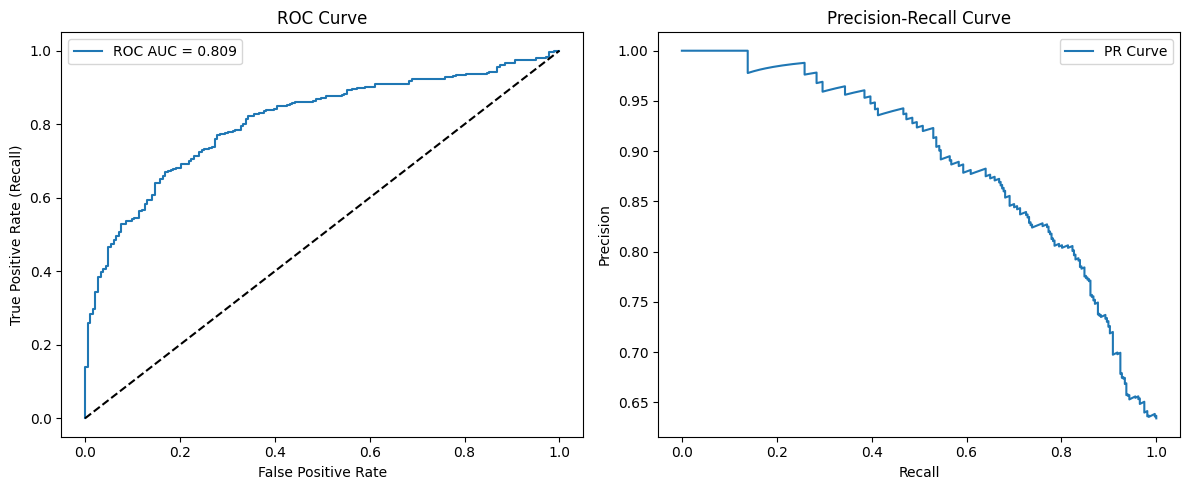

🎯 Оптимальный threshold по F1: 0.0479
🔁 Precision: 0.7843 | Recall: 0.8486 | F1: 0.8152


In [54]:
best_threshold = plot_threshold_metrics(trues, probs)